In [1]:
import torch
import mlflow
from utils.custom_dataset import get_card_dataset

from config import RAW_DATA_DIR

2025-07-18 13:32:29.978 | INFO     | config:<module>:9 - PROJ_ROOT path is: /home/arys/projects/unsupervised_ml_experimentation


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from IPython.display import HTML

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)



train_dataset = get_card_dataset()


batch_size = 2
train_dl = torch.utils.data.DataLoader(get_card_dataset(), batch_size=batch_size, shuffle=True, num_workers=6)

### Set Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import math
class VAE(nn.Module):
    def __init__(self, latent_dim=2, input_size=28 * 28):
        super().__init__()
        self.input_size: int = input_size
        self.latent_dim: int = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.fn_mu = nn.Linear(32, self.latent_dim)
        self.fn_logvar = nn.Linear(32, self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()
        )
    def forward_dec(self, x):
        return self.decoder(x)

    def forward_enc(self, x):

        x = self.encoder(x)
        mu = self.fn_mu(x)
        logvar = self.fn_logvar(x)

        sigma = torch.exp(0.5 * logvar)
        noise = torch.randn_like(logvar, device=logvar.device)

        z = mu + sigma * noise
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.forward_enc(x)

        return z, self.decoder(z), mu, logvar



In [5]:
def VAELoss(x, x_hat, mean, log_var, kl_weight=1, reconstruction_weight=1):
    pixel_mse = ((x - x_hat)**2)

    #reconstruction_loss = pixel_mse.sum(axis=-1).mean()
    reconstruction_loss = pixel_mse.mean()


    kl = (1 + log_var - mean**2 - torch.exp(log_var))

    kl_per_image = -0.5 * torch.sum(kl, dim=-1)


    kl_loss = torch.mean(kl_per_image)
    #print(reconstruction_loss, kl_loss)

    return reconstruction_loss, kl_loss, reconstruction_loss * reconstruction_weight + kl_weight * kl_loss

x = torch.randn(4, 128)
x_hat = torch.randn(4, 128)

mean = torch.randn(4, 2)
log_var = torch.randn(4, 2)

VAELoss(x, x_hat, mean, log_var)


(tensor(2.2515), tensor(1.6551), tensor(3.9065))

# Trainning

In [6]:
from loguru import logger
mlflow.set_experiment("unsupervized_ml_sandbox")

logger.info(f"model_name : VAE")



2025-07-18 13:32:40.277 | INFO     | __main__:<module>:4 - model_name : VAE


In [7]:
train_dataset.data.shape

torch.Size([8154, 12288])

In [8]:
# with mlflow.start_run(run_name="vae_cards"):
#     kl_weight = 0.1
#     input_size = 12288
#     epochs = 100
#     model = VAE(latent_dim=2, input_size=input_size).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=0.0005)
#     val_step = 5
#
#
#     mlflow.log_param("kl_weight", kl_weight)
#     mlflow.log_param("input_size", input_size)
#     mlflow.log_param("epochs", epochs)
#     mlflow.log_param("model", model)
#     mlflow.log_param("optimizer", optimizer)
#     mlflow.log_param("val_step", val_step)
#
#
#     torch.set_float32_matmul_precision('high')
#
#     train_loss = []
#
#     encoded_data_per_eval = []
#     train_losses =[]
#     r_losses = []
#     kl_losses = []
#     val_losses =[]
#
#
#     model.train()
#
#     train = True
#
#     for epoch in tqdm(range(epochs)):
#         train_loss_epoch = []
#         r_loss_epoch = []
#         kl_loss_epoch = []
#
#         for imgs, _ in train_dl:
#             imgs = imgs.to(device)
#
#             encoded, decoded, mu, logvar = model(imgs)
#
#             r_loss, kl_loss, loss = VAELoss(imgs, decoded, mu, logvar, kl_weight=kl_weight)
#
#             train_loss_epoch.append(loss.item())
#             r_loss_epoch.append(r_loss.item())
#             kl_loss_epoch.append(kl_loss.item())
#
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#
#         train_losses.append(np.mean(train_loss_epoch))
#         kl_losses.append(np.mean(kl_loss_epoch))
#         r_losses.append(np.mean(r_loss_epoch))
#
#
#
#         if epoch % val_step == 0:
#
#             avg_train_loss = np.mean(train_losses)
#             avg_kl_loss = np.mean(kl_losses)
#             avg_r_loss = np.mean(r_losses)
#
#             print(f"Epoch {epoch} — train_loss: {avg_train_loss:.6f} ")
#             mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
#             mlflow.log_metric("kl_loss", avg_kl_loss, step=epoch)
#             mlflow.log_metric("r_loss", avg_r_loss, step=epoch)
#                     # on sauvegarde les moyennes
#
#             train_losses = []
#             kl_losses = []
#             r_losses = []
#
#
#             model.train()
#
#



In [9]:
model = VAE(latent_dim=2, input_size=12288).to(device)
model.load_state_dict(torch.load("vae.pt"))

<All keys matched successfully>

In [10]:
# encoded_data_per_eval = []
# decoded_data_per_eval = []
# encoded_labels_per_eval = []
# raw_data_per_eval = []
#
# model.eval()
#
# for imgs, label in train_dl:
#     imgs = imgs.to(device)
#     imgs = imgs.flatten(1)
#     encoded, decoded, _, _ = model(imgs)
#     encoded_data_per_eval.append(encoded)
#     encoded_labels_per_eval.append(label)
#     decoded_data_per_eval.append(decoded)
#     raw_data_per_eval.append(imgs)
#
#
# encoded_data = torch.cat(encoded_data_per_eval, dim=0)
# encoded_labels = torch.cat(encoded_labels_per_eval, dim=0)
# decoded_data = torch.cat(decoded_data_per_eval, dim=0)
# raw_data = torch.cat(raw_data_per_eval, dim=0)

encoded_data_per_eval = []
decoded_data_per_eval = []
raw_data_per_eval = []
device = "cuda"

model.eval()

print(device)
for imgs in train_dl:
    imgs = imgs.to(device)
    encoded, decoded, _, _ = model(imgs)
    encoded_data_per_eval.append(encoded)
    decoded_data_per_eval.append(decoded)
    raw_data_per_eval.append(imgs)


encoded_data = torch.cat(encoded_data_per_eval, dim=0)
decoded_data = torch.cat(decoded_data_per_eval, dim=0)
raw_data = torch.cat(raw_data_per_eval, dim=0)


cuda


## Représentation dans l'espace latent

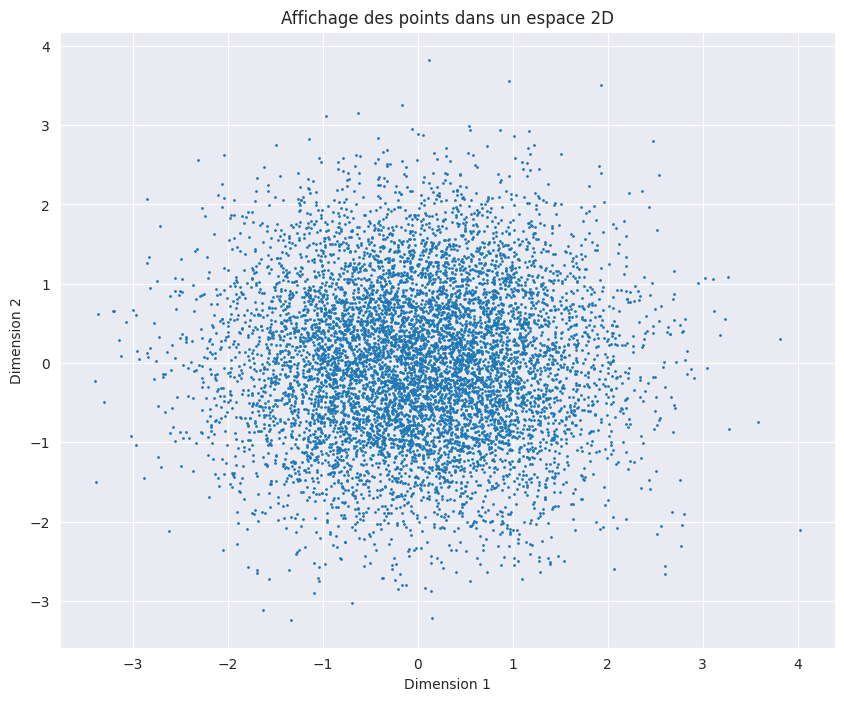

In [11]:
np_encoded_data = encoded_data.detach().cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(np_encoded_data[:, 0], np_encoded_data[:, 1], s=1) # s est la taille des points
plt.title('Affichage des points dans un espace 2D')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# encodeur -> decodeur

In [12]:
print(raw_data.shape, decoded_data.shape)

torch.Size([8154, 12288]) torch.Size([8154, 12288])


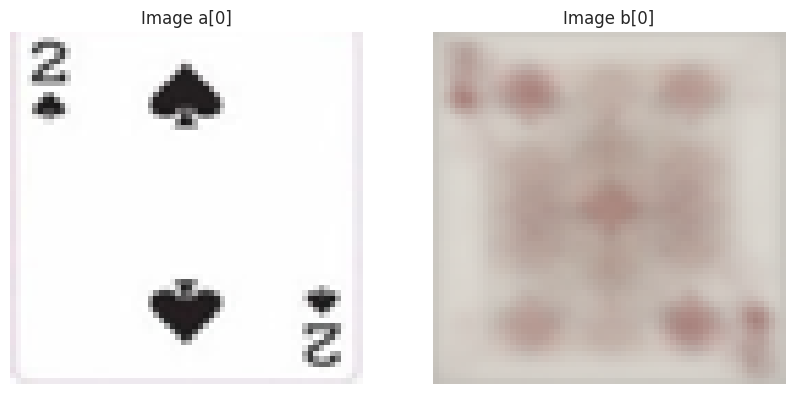

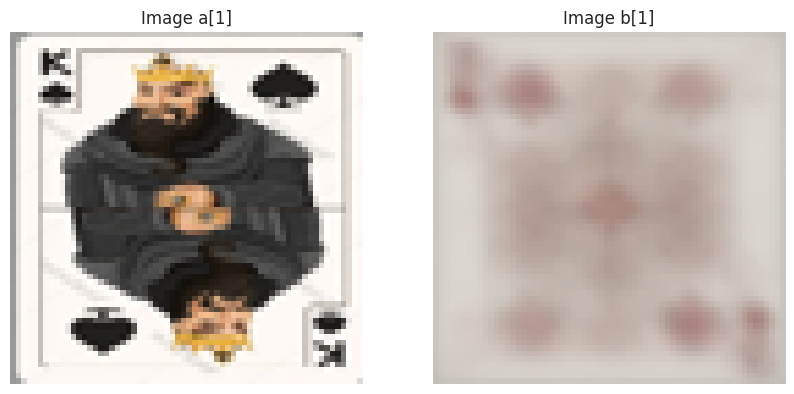

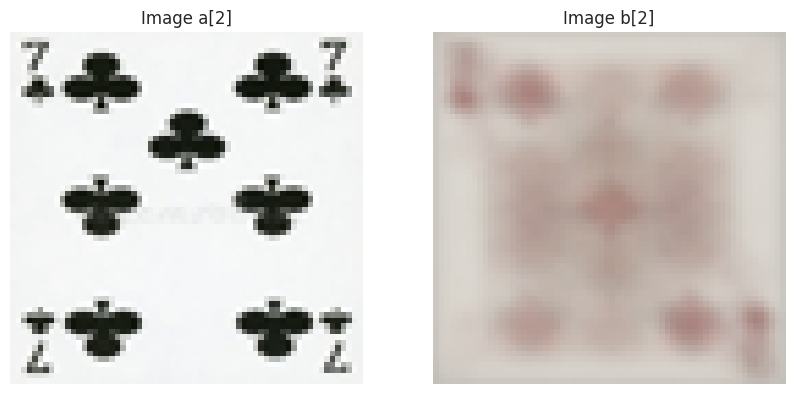

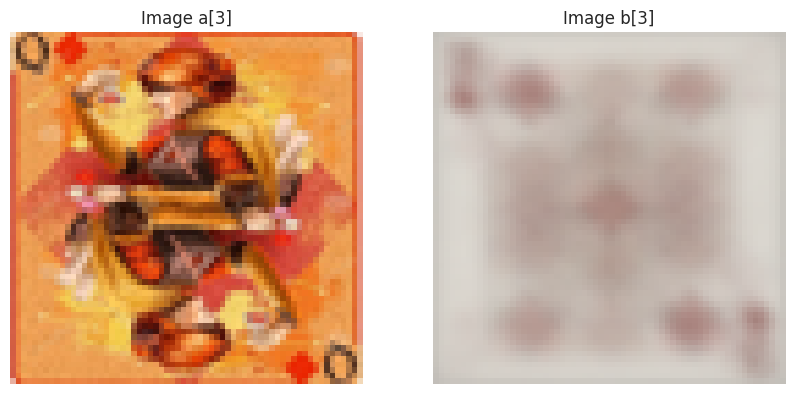

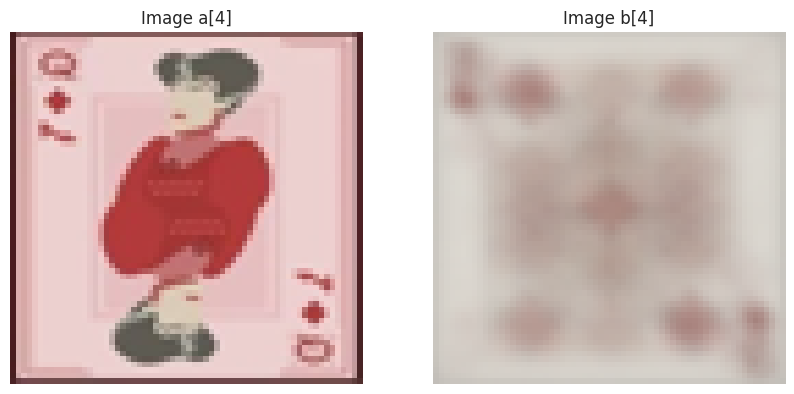

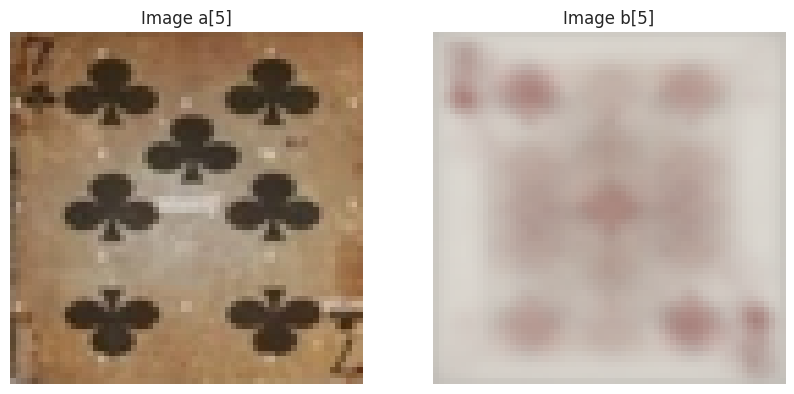

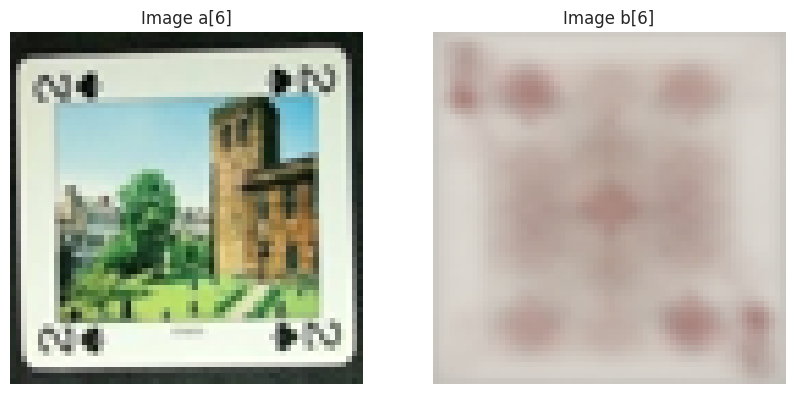

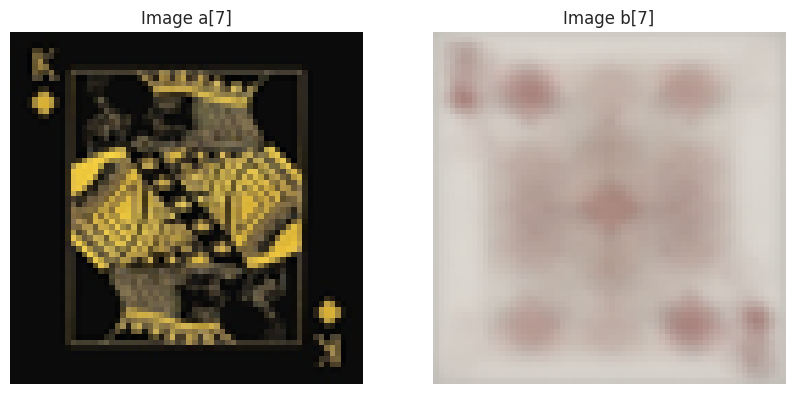

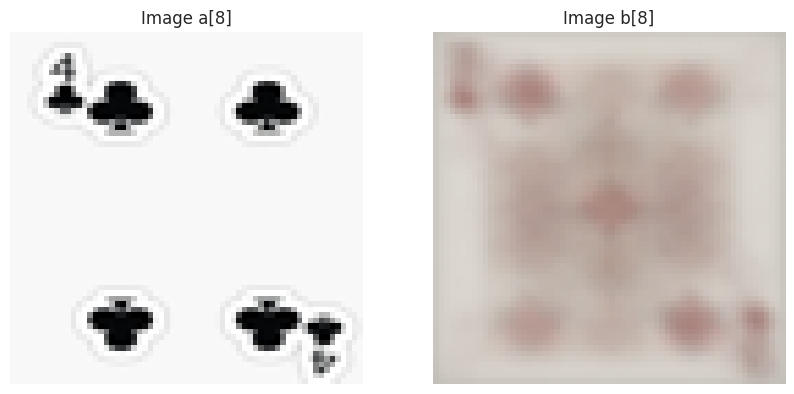

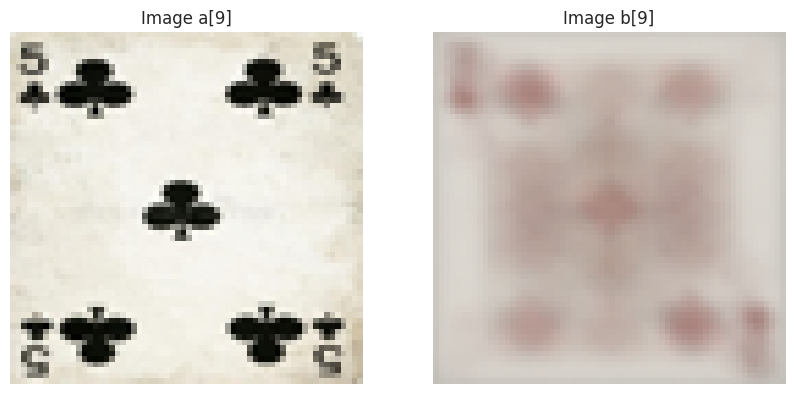

In [13]:
import numpy as np
np_decoded_data = decoded_data.detach().cpu().numpy()
np_raw_data = raw_data.detach().cpu().numpy()
for i in range(10):
    # Transformation des vecteurs en images 28x28
    image_a = np_raw_data[i].reshape(64, 64, 3)
    image_b = np_decoded_data[i].reshape(64, 64, 3)
    # image_a = np.clip(image_a, 0, 255).astype(np.uint8)
    # image_b = np.clip(image_b, 0, 255).astype(np.uint8)

    # Création d'une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage des images
    axes[0].imshow(image_a, cmap='gray')
    axes[0].set_title(f'Image a[{i}]')
    axes[0].axis('off')

    axes[1].imshow(image_b, cmap='gray')
    axes[1].set_title(f'Image b[{i}]')
    axes[1].axis('off')

In [14]:
import numpy as np
points = np_encoded_data
# Définir les limites du quadrillage
x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()
grid_size = 10
x_coords = np.linspace(x_min, x_max, grid_size)
y_coords = np.linspace(y_min, y_max, grid_size)

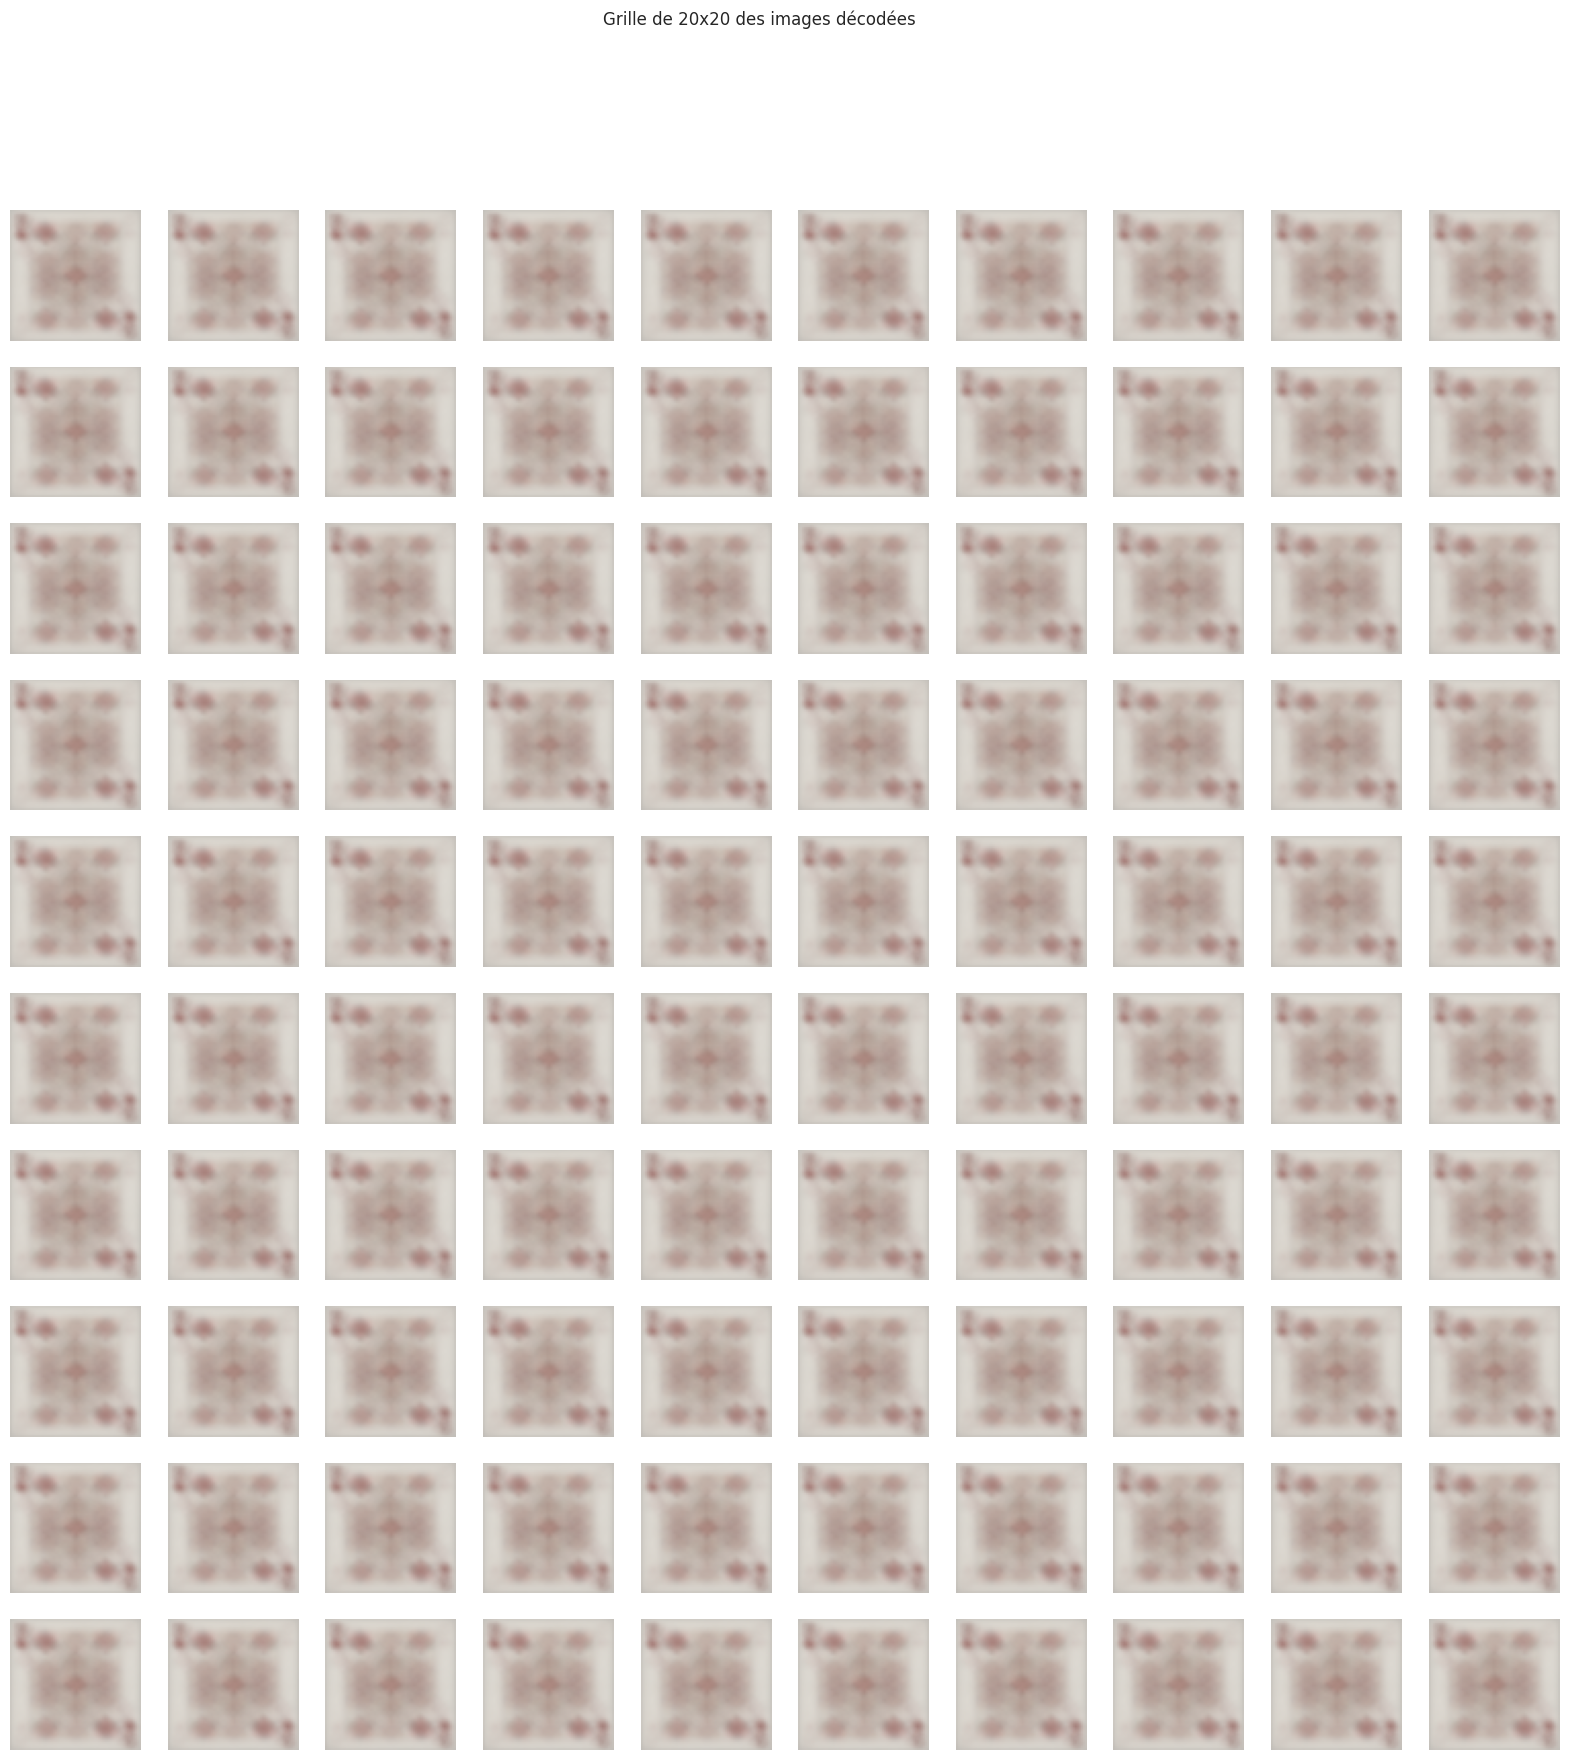

In [15]:
# Trouver le point le plus proche pour chaque cellule de la grille
plt.figure(figsize=(20, 20))
for i in range(grid_size):
    for j in range(grid_size):
        # Trouver le point le plus proche de la cellule (i, j)
        x, y = x_coords[i], y_coords[j]
        tensor = torch.tensor([x, y], dtype=torch.float32).to(device)
        pt = model.forward_dec(tensor)


        pt = pt.detach().cpu().numpy()



        image = pt.reshape(64, 64, 3)
        # image = np.clip(image, 0, 255).astype(np.uint8)

        # Afficher l'image dans la grille
        plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

plt.suptitle('Grille de 20x20 des images décodées')
plt.show()